In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.svm import SVC
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
combined_df= pd.read_csv('cp_smiles_df.csv')
combined_df.head()

In [148]:
combined_df=combined_df.drop(columns=['SMILES','moa','Unnamed: 0'])

In [187]:
batch_ids_by_class = combined_df.groupby('moa_encoded')['batch_encoded'].unique().to_dict()

# Step 2: Create a dictionary to hold train and test batch_ids
train_batches = []
test_batches = []


# Step 3: Split each class into train and test while ensuring batch_ids do not overlap
for moa_class, batch_ids in batch_ids_by_class.items():
    train, test = train_test_split(batch_ids, test_size=0.2, random_state=42)
    train_batches.extend(train)
    test_batches.extend(test)

# Step 4: Create the train and test DataFrames based on batch_ids
train_df = combined_df[combined_df['batch_encoded'].isin(train_batches)].reset_index(drop=True)
test_df = combined_df[combined_df['batch_encoded'].isin(test_batches)].reset_index(drop=True)

In [188]:
train_set=set(train_df['batch_encoded'].unique())
test_set=set(test_df['batch_encoded'].unique())
common_batch_ids = train_set.intersection(test_set)

if common_batch_ids:
    print("Common comp present in both train and test sets:")
    print(common_batch_ids)
else:
    print("No common comp present in both sets.")

No common comp present in both sets.


In [189]:
batch_ids_by_class = train_df.groupby('moa_encoded')['batch_encoded'].unique().to_dict()

# Step 2: Create a dictionary to hold train and validation batch_ids
train_batches = []
val_batches = []


for moa_class, batch_ids in batch_ids_by_class.items():
    train, val = train_test_split(batch_ids, test_size=0.2, random_state=42)
    train_batches.extend(train)
    val_batches.extend(val)

train_final_df = train_df[train_df['batch_encoded'].isin(train_batches)].reset_index(drop=True)
val_df = train_df[train_df['batch_encoded'].isin(val_batches)].reset_index(drop=True)

In [190]:
train_final_df['moa_encoded'].value_counts()

moa_encoded
9     435
3     433
10    431
0     413
11    396
1     394
2     394
6     378
7     354
13    334
8     324
5     324
4     323
12    313
Name: count, dtype: int64

In [191]:
train_final_df=train_final_df.drop(columns=['batch_encoded'],inplace=False)
val_df=val_df.drop(columns=['batch_encoded'],inplace=False)
test_df=test_df.drop(columns=['batch_encoded'],inplace=False)

In [192]:
train_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,503.1,504.1,505.1,506.1,507.1,508.1,509.1,510.1,511.1,moa_encoded
0,0.511129,-1.564793,-0.634613,-0.5164,-1.094807,0.387904,0.552314,0.822139,-0.562627,1.734652,...,1.165513,-1.254139,0.044322,0.309432,1.303659,0.37675,0.435339,-1.079867,0.830855,1


In [193]:
X_train = train_final_df.drop(['moa_encoded'], axis=1)
y_train = train_final_df['moa_encoded']
X_val = val_df.drop(['moa_encoded'], axis=1)
y_val=val_df['moa_encoded']
X_test = test_df.drop(['moa_encoded'], axis=1)
y_test=test_df['moa_encoded']

In [194]:
scaler=StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s=scaler.transform(X_val)
X_test_s=scaler.transform(X_test)

In [195]:
train_final_df.shape

(5246, 1380)

In [196]:
val_df.shape

(1592, 1380)

In [142]:
knn = KNeighborsClassifier(n_neighbors=141,weights='uniform',metric='euclidean')  
knn.fit(X_train_s, y_train) 
y_train_pred_knn = knn.predict(X_train_s)
train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
print(f'Training Accuracy knn: {train_acc_knn:.2f}')

Training Accuracy knn: 0.70


In [143]:
y_val_pred_knn = knn.predict(X_val_s)
val_accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
print(f"Validation Accuracy knn: {val_accuracy_knn:.2f}")

Validation Accuracy knn: 0.35


In [144]:
y_test_pred_knn = knn.predict(X_test_s)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f"test Accuracy knn: {test_accuracy_knn:.2f}")

test Accuracy knn: 0.43


In [211]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       179
           1       0.34      0.36      0.35       173
           2       0.30      0.39      0.34       166
           3       0.41      0.98      0.58       123
           4       0.00      0.00      0.00       144
           5       0.70      0.65      0.67       108
           6       0.00      0.00      0.00       141
           7       0.66      0.50      0.57       143
           8       0.00      0.00      0.00       108
           9       0.52      0.99      0.68       146
          10       0.19      0.14      0.16       125
          11       0.00      0.01      0.01       144
          12       0.00      0.00      0.00       108
          13       0.67      0.75      0.71       133

    accuracy                           0.40      1941
   macro avg       0.34      0.39      0.35      1941
weighted avg       0.35      0.40      0.36      1941



In [212]:
print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           0       0.93      0.22      0.35       179
           1       0.25      0.35      0.29       173
           2       0.97      0.17      0.30       166
           3       0.33      0.96      0.49       123
           4       0.29      0.26      0.28       144
           5       0.55      0.67      0.61       108
           6       0.77      0.17      0.28       141
           7       0.66      0.75      0.70       143
           8       0.10      0.19      0.13       108
           9       0.55      0.95      0.69       146
          10       0.50      0.40      0.44       125
          11       0.52      0.44      0.48       144
          12       0.00      0.00      0.00       108
          13       0.82      0.53      0.64       133

    accuracy                           0.43      1941
   macro avg       0.52      0.43      0.41      1941
weighted avg       0.54      0.43      0.41      1941



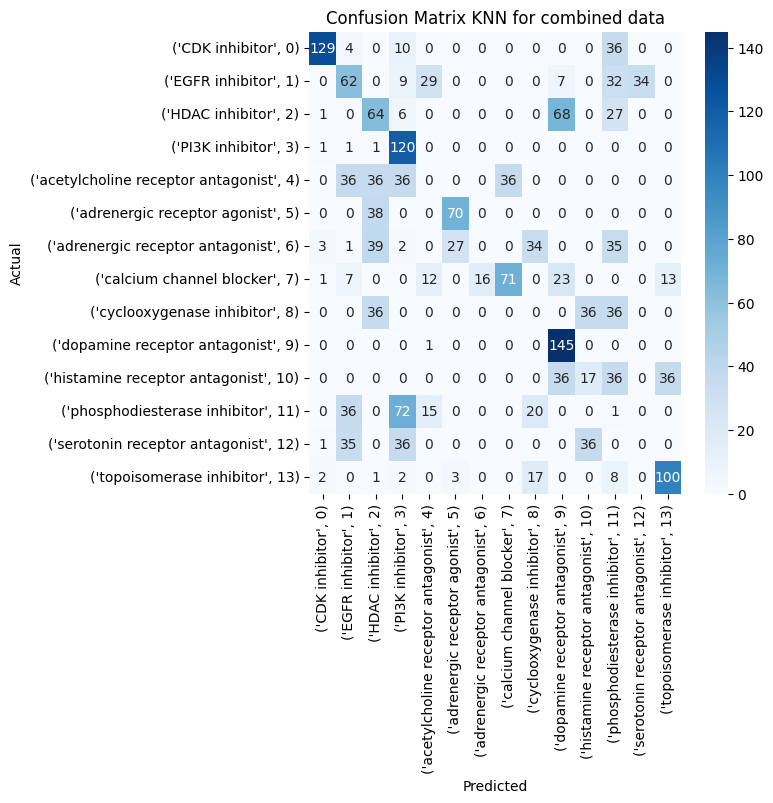

In [219]:
cm = confusion_matrix(y_test, y_test_pred)
class_names = [
    ('CDK inhibitor', 0), 
    ('EGFR inhibitor', 1), 
    ('HDAC inhibitor', 2), 
    ('PI3K inhibitor', 3), 
    ('acetylcholine receptor antagonist', 4), 
    ('adrenergic receptor agonist', 5), 
    ('adrenergic receptor antagonist', 6), 
    ('calcium channel blocker', 7), 
    ('cyclooxygenase inhibitor', 8), 
    ('dopamine receptor antagonist', 9), 
    ('histamine receptor antagonist', 10), 
    ('phosphodiesterase inhibitor', 11), 
    ('serotonin receptor antagonist', 12), 
    ('topoisomerase inhibitor', 13)
]
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix KNN for combined data')
plt.show()

In [109]:

from sklearn.model_selection import GridSearchCV


# Define the parameter grid
param_grid = {
    'degree': range(1, 5),  # Degrees from 1 to 10
    'coef0': range(0, 2),   # coef0 values 0 and 1
    'C': [x * 0.1 for x in range(1, 5)]  # C values from 0.1 to 1.0
}

# Initialize the model
svm_poly = SVC(kernel='poly', probability=True, random_state=2)

# Perform Grid Search
grid_search = GridSearchCV(svm_poly, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_s, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_train_pred_poly = best_model.predict(X_train_s)
train_acc = accuracy_score(y_train, y_train_pred_poly)

print(f'Best Parameters: {best_params}')
print(f'Training Accuracy with Best Parameters: {train_acc:.2f}')


Best Parameters: {'C': 0.4, 'coef0': 1, 'degree': 2}
Training Accuracy with Best Parameters: 1.00


In [17]:
svm_poly = SVC(kernel='poly', degree=2, coef0=1, C=0.4,probability=True, random_state=2)
svm_poly.fit(X_train_s, y_train)
y_train_pred_poly = svm_poly.predict(X_train_s)
train_acc = accuracy_score(y_train, y_train_pred_poly)
print(f'Training Accuracy: {train_acc:.2f}')

Training Accuracy: 1.00


In [19]:
y_test_pred_poly = svm_poly.predict(X_test_s)
test_accuracy_poly = accuracy_score(y_test, y_test_pred_poly)
print(f"test Accuracy poly: {test_accuracy_poly:.2f}")

test Accuracy poly: 0.50


In [18]:
y_val_pred_poly = svm_poly.predict(X_val_s)
val_accuracy_poly = accuracy_score(y_val, y_val_pred_poly)
print(f"Validation Accuracy: {val_accuracy_poly:.2f}")

Validation Accuracy: 0.48


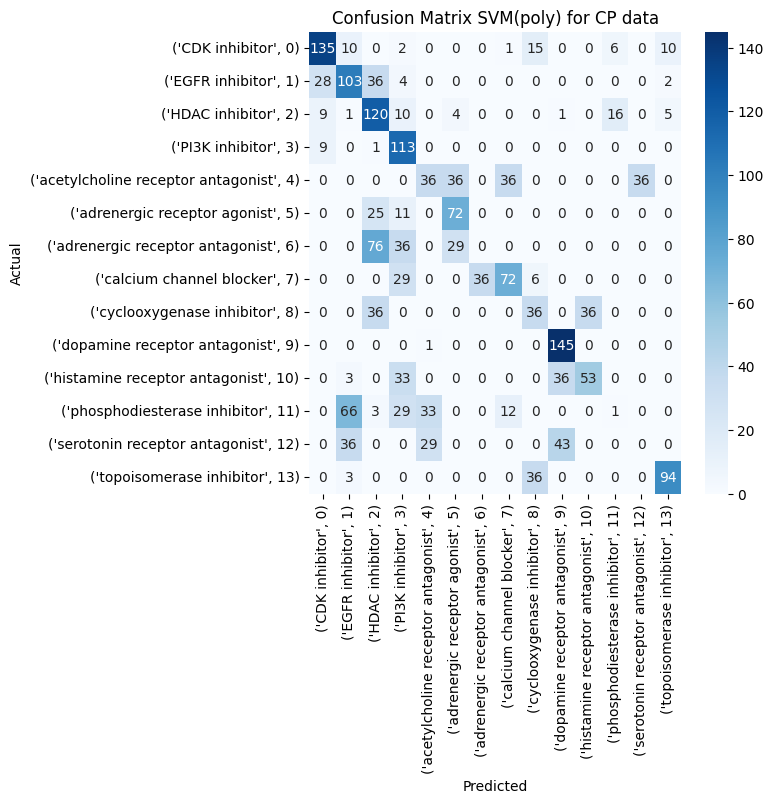

In [225]:
cm = confusion_matrix(y_test, y_test_pred_poly)
class_names = [
    ('CDK inhibitor', 0), 
    ('EGFR inhibitor', 1), 
    ('HDAC inhibitor', 2), 
    ('PI3K inhibitor', 3), 
    ('acetylcholine receptor antagonist', 4), 
    ('adrenergic receptor agonist', 5), 
    ('adrenergic receptor antagonist', 6), 
    ('calcium channel blocker', 7), 
    ('cyclooxygenase inhibitor', 8), 
    ('dopamine receptor antagonist', 9), 
    ('histamine receptor antagonist', 10), 
    ('phosphodiesterase inhibitor', 11), 
    ('serotonin receptor antagonist', 12), 
    ('topoisomerase inhibitor', 13)
]
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix SVM(poly) for CP data')
plt.show()

In [221]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,  # Number of trees in the forest
    max_depth=8,  
    min_samples_split=20, 
    min_samples_leaf=5,  
    max_features=0.2,  # Number of features considered for best split
    bootstrap=True,  
    random_state=4
)
rf.fit(X_train_s, y_train)
y_train_pred_rf = rf.predict(X_train_s)
train_acc = accuracy_score(y_train, y_train_pred_rf)
print(f'Training Accuracy rf: {train_acc:.2f}')

Training Accuracy rf: 1.00


In [ ]:
y_val_pred_rf = rf.predict(X_val_s)
val_accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f"Validation Accuracy rf: {val_accuracy:.2f}")

In [227]:
y_test_pred = rf.predict(X_test_s)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"test Accuracy rf: {test_accuracy:.2f}")

test Accuracy rf: 0.40


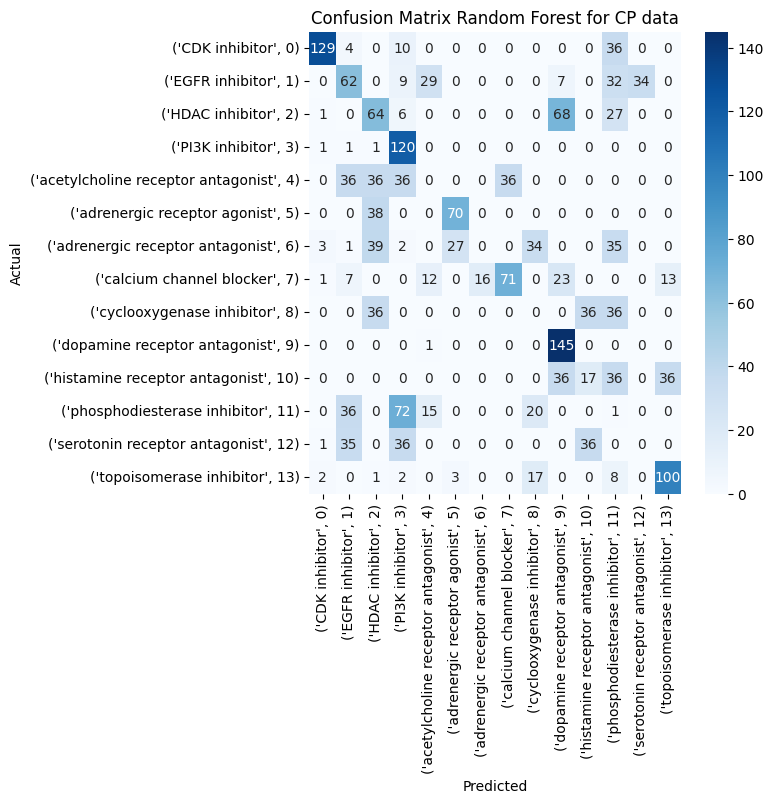

In [228]:
cm = confusion_matrix(y_test, y_test_pred)
class_names = [
    ('CDK inhibitor', 0), 
    ('EGFR inhibitor', 1), 
    ('HDAC inhibitor', 2), 
    ('PI3K inhibitor', 3), 
    ('acetylcholine receptor antagonist', 4), 
    ('adrenergic receptor agonist', 5), 
    ('adrenergic receptor antagonist', 6), 
    ('calcium channel blocker', 7), 
    ('cyclooxygenase inhibitor', 8), 
    ('dopamine receptor antagonist', 9), 
    ('histamine receptor antagonist', 10), 
    ('phosphodiesterase inhibitor', 11), 
    ('serotonin receptor antagonist', 12), 
    ('topoisomerase inhibitor', 13)
]
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Random Forest for CP data')
plt.show()

In [210]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       179
           1       0.34      0.36      0.35       173
           2       0.30      0.39      0.34       166
           3       0.41      0.98      0.58       123
           4       0.00      0.00      0.00       144
           5       0.70      0.65      0.67       108
           6       0.00      0.00      0.00       141
           7       0.66      0.50      0.57       143
           8       0.00      0.00      0.00       108
           9       0.52      0.99      0.68       146
          10       0.19      0.14      0.16       125
          11       0.00      0.01      0.01       144
          12       0.00      0.00      0.00       108
          13       0.67      0.75      0.71       133

    accuracy                           0.40      1941
   macro avg       0.34      0.39      0.35      1941
weighted avg       0.35      0.40      0.36      1941



In [29]:
from sklearn.utils import class_weight
y_unique = np.unique(np.array(y_train))
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes = y_unique,
                y = np.array(y_train)) 
class_weights_dict45 = dict(enumerate(class_weights))
class_weights_dict45

{0: np.float64(0.9072985126253892),
 1: np.float64(0.9510514865844815),
 2: np.float64(0.9510514865844815),
 3: np.float64(0.8653909600791818),
 4: np.float64(1.1601061477222467),
 5: np.float64(1.15652557319224),
 6: np.float64(0.9913076341647771),
 7: np.float64(1.0585149313962874),
 8: np.float64(1.15652557319224),
 9: np.float64(0.8614121510673235),
 10: np.float64(0.8694066953927743),
 11: np.float64(0.9462481962481962),
 12: np.float64(1.1971702418986765),
 13: np.float64(1.1218990590248075)}

In [197]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # If using CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_s, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_valid_tensor = torch.tensor(X_val_s, dtype=torch.float32).to(device)
y_valid_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Define the MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, num_classes)  # Direct output layer

        self.dropout = nn.Dropout(0.5)  # Less aggressive dropout
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)  # Final output
        return x


# Initialize the model
input_dim = X_train.shape[1]
num_classes = 14  # Your number of classes
model = MLP(input_dim, num_classes).to(device)

# Convert class weights to tensor
class_weights = torch.tensor(list(class_weights_dict45.values()), dtype=torch.float32).to(device)

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Uses class weights
optimizer = optim.Adam(model.parameters(), lr=4e-6, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7)

# Early stopping setup
patience = 15
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in valid_loader:
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_val).sum().item()
            total += y_val.size(0)
    
    val_acc = correct / total
    val_loss /= len(valid_loader)
    scheduler.step(val_loss)  # Adjust learning rate if needed
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #torch.save(model.state_dict(), "best_mlp_model.txt")  # Save the best model
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

# Load the best model
best_model = MLP(input_dim, num_classes).to(device)
#best_model.load_state_dict(torch.load("best_mlp_model.txt"))
best_model.eval()

Epoch 1/1000 - Loss: 220.8991, Val Loss: 2.6036, Val Acc: 0.1162
Epoch 2/1000 - Loss: 212.6034, Val Loss: 2.5316, Val Acc: 0.1765
Epoch 3/1000 - Loss: 203.3532, Val Loss: 2.4700, Val Acc: 0.2098
Epoch 4/1000 - Loss: 194.5239, Val Loss: 2.4087, Val Acc: 0.2412
Epoch 5/1000 - Loss: 185.7905, Val Loss: 2.3608, Val Acc: 0.2732
Epoch 6/1000 - Loss: 179.7737, Val Loss: 2.3097, Val Acc: 0.2927
Epoch 7/1000 - Loss: 172.4823, Val Loss: 2.2656, Val Acc: 0.3103
Epoch 8/1000 - Loss: 166.0610, Val Loss: 2.2285, Val Acc: 0.3266
Epoch 9/1000 - Loss: 160.4393, Val Loss: 2.1943, Val Acc: 0.3379
Epoch 10/1000 - Loss: 154.7779, Val Loss: 2.1628, Val Acc: 0.3675
Epoch 11/1000 - Loss: 149.6043, Val Loss: 2.1253, Val Acc: 0.3719
Epoch 12/1000 - Loss: 144.5731, Val Loss: 2.0959, Val Acc: 0.3888
Epoch 13/1000 - Loss: 139.9880, Val Loss: 2.0716, Val Acc: 0.3982
Epoch 14/1000 - Loss: 134.5031, Val Loss: 2.0373, Val Acc: 0.4064
Epoch 15/1000 - Loss: 131.0164, Val Loss: 2.0222, Val Acc: 0.4146
Epoch 16/1000 - Los

MLP(
  (fc1): Linear(in_features=1379, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=14, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): LeakyReLU(negative_slope=0.01)
)

In [198]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test_s, dtype=torch.float32).to(device)
best_model.eval()
best_model.to(device)
X_test_tensor = X_test_tensor.to(device)
with torch.no_grad():  # Disable gradient computation
    logits = best_model(X_test_tensor)  # Forward pass
    predictions = torch.argmax(logits, dim=1)  

In [199]:
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)  # Ensure dtype matches
accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predictions.cpu().numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 12.11%


In [327]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [333]:
combined_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,503.1,504.1,505.1,506.1,507.1,508.1,509.1,510.1,511.1,moa_encoded
0,0,0.511129,-1.564793,-0.634613,-0.516400,-1.094807,0.387904,0.552314,0.822139,-0.562627,...,1.165513,-1.254139,0.044322,0.309432,1.303659,0.376750,0.435339,-1.079867,0.830855,1
1,1,0.086427,-0.275485,-0.878129,-0.459353,-0.651173,0.294491,0.479656,0.971761,0.296772,...,1.591558,0.152989,-0.442737,-0.087406,2.030234,-0.296892,0.410483,0.279842,0.778085,1
2,2,0.191841,-0.837368,0.879227,-0.312856,-0.445408,0.178821,0.302910,-1.389613,-0.331266,...,0.634585,0.329275,0.977226,-0.209657,1.808493,1.641739,1.772522,-1.015708,0.841071,1
3,3,0.072265,-0.253647,-0.358873,-0.175158,0.094171,0.257840,0.140739,0.543537,-1.144795,...,0.467169,1.014107,0.001339,-0.407308,-1.024301,0.313306,0.333303,-0.464103,0.850689,1
4,4,0.263156,1.294163,0.306848,-0.145710,-0.377146,0.433498,0.106513,1.265929,1.073820,...,0.164616,0.453401,-0.519115,0.163432,1.211386,1.683206,-0.232252,-1.298770,0.994058,1


In [88]:

meta = combined_df[['moa_encoded','batch_encoded']]
feat = combined_df[[col for col in combined_df if col not in meta.columns]]

In [89]:
import scanpy as sc
adata = sc.AnnData(X=feat,obs=meta)
adata

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 8779 × 1379
    obs: 'moa_encoded', 'batch_encoded'

In [90]:
scaler=StandardScaler()

In [91]:
feat=scaler.fit_transform(feat)

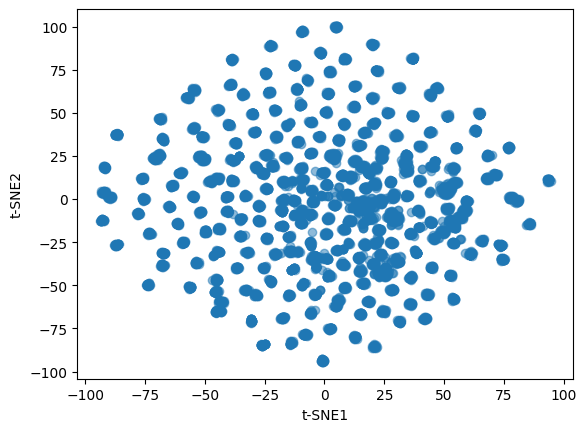

In [92]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(feat)  # Subsample if large

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.show()

In [203]:
print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           0       0.93      0.22      0.35       179
           1       0.25      0.35      0.29       173
           2       0.97      0.17      0.30       166
           3       0.33      0.96      0.49       123
           4       0.29      0.26      0.28       144
           5       0.55      0.67      0.61       108
           6       0.77      0.17      0.28       141
           7       0.66      0.75      0.70       143
           8       0.10      0.19      0.13       108
           9       0.55      0.95      0.69       146
          10       0.50      0.40      0.44       125
          11       0.52      0.44      0.48       144
          12       0.00      0.00      0.00       108
          13       0.82      0.53      0.64       133

    accuracy                           0.43      1941
   macro avg       0.52      0.43      0.41      1941
weighted avg       0.54      0.43      0.41      1941



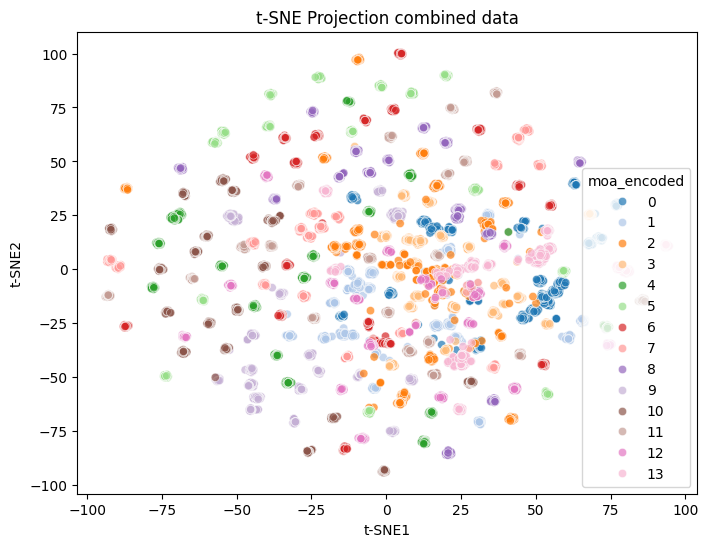

In [202]:
tsne_df = pd.DataFrame(tsne_result, columns=["t-SNE1", "t-SNE2"])
tsne_df["moa_encoded"] = combined_df["moa_encoded"].astype("category")  # Ensure the index aligns
palette = sns.color_palette("tab20", n_colors=len(tsne_df["moa_encoded"].cat.categories))
hue_order = sorted(tsne_df["moa_encoded"].unique())

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="t-SNE1",
    y="t-SNE2",
    hue="moa_encoded",
    palette="tab20",  # Change palette as needed
    data=tsne_df,
    alpha=0.7
)

plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE Projection combined data")
plt.legend(title="moa_encoded")
plt.show()

MOA Mapping: [('CDK inhibitor', 0), ('EGFR inhibitor', 1), ('HDAC inhibitor', 2), ('PI3K inhibitor', 3), ('acetylcholine receptor antagonist', 4), ('adrenergic receptor agonist', 5), ('adrenergic receptor antagonist', 6), ('calcium channel blocker', 7), ('cyclooxygenase inhibitor', 8), ('dopamine receptor antagonist', 9), ('histamine receptor antagonist', 10), ('phosphodiesterase inhibitor', 11), ('serotonin receptor antagonist', 12), ('topoisomerase inhibitor', 13)]

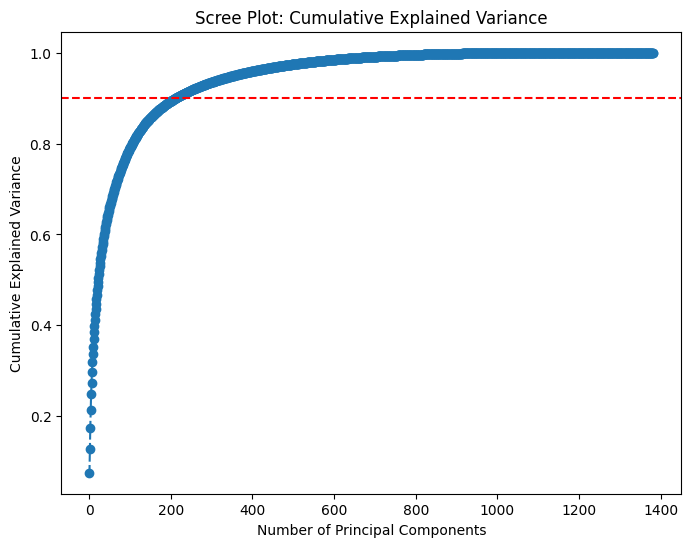

In [345]:
#scaler=StandardScaler()
#test_pca=scaler.fit_transform(feat)
df_pca=pd.DataFrame(feat)
pca = PCA()
pca.fit(df_pca)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--')  
plt.show()

In [349]:
combined_df['moa_encoded'].unique()

array([ 1,  9,  0,  3, 10,  2, 11,  6,  7, 13,  4,  8,  5, 12])

In [357]:
combined_df['batch_encoded']

0       160
1       151
2       247
3       268
4       207
       ... 
8774    258
8775    258
8776    258
8777    258
8778    258
Name: batch_encoded, Length: 8779, dtype: int64

In [95]:
adata

AnnData object with n_obs × n_vars = 8779 × 1379
    obs: 'moa_encoded', 'batch_encoded'

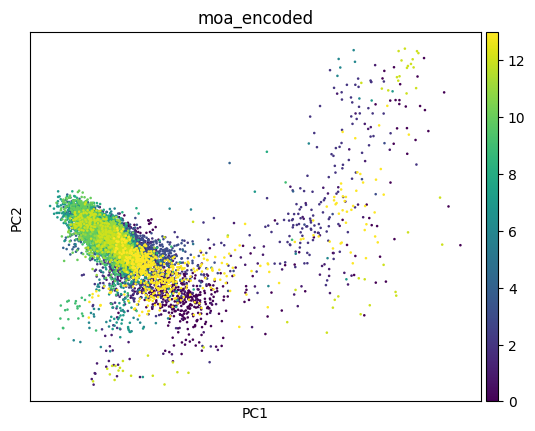

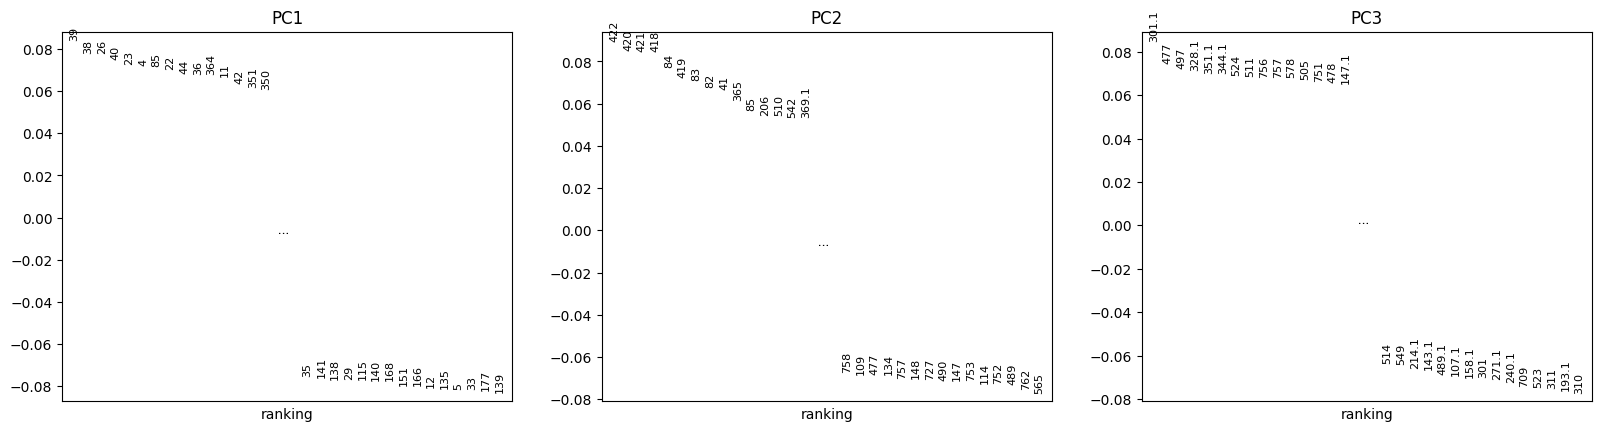

In [96]:
sc.tl.pca(adata,n_comps=250)
sc.pl.pca(adata,color='moa_encoded')
sc.pl.pca_loadings(adata)

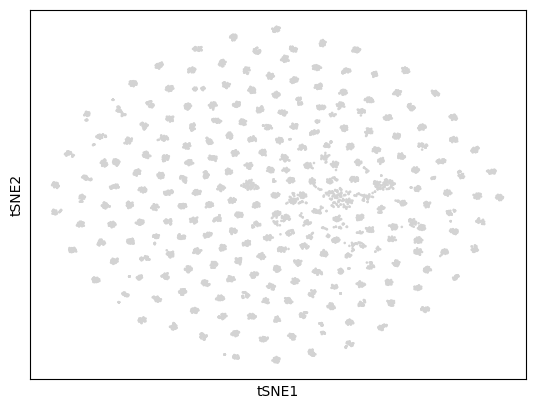

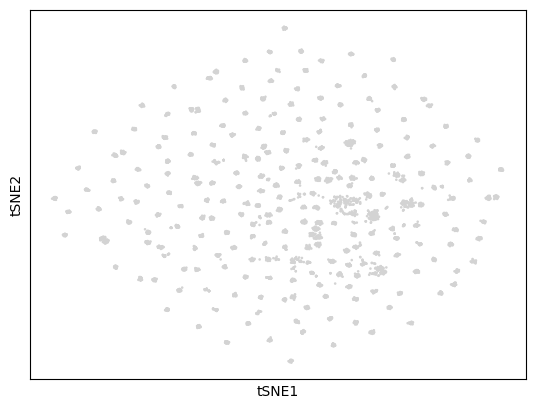

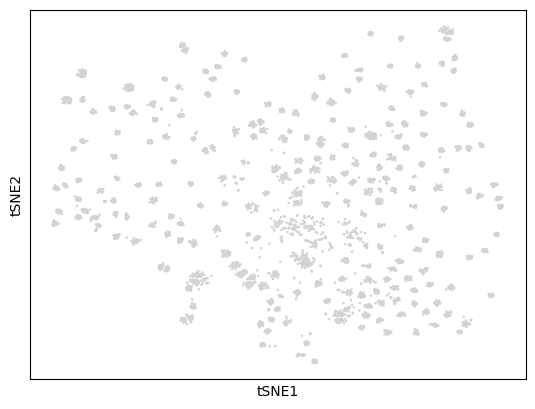

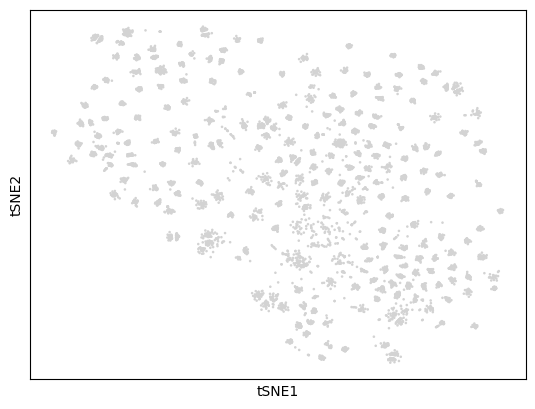

In [204]:
sc.tl.tsne(adata,perplexity=10)
sc.pl.tsne(adata)
sc.tl.tsne(adata,perplexity=30)
sc.pl.tsne(adata)
sc.tl.tsne(adata,perplexity=100)
sc.pl.tsne(adata)
sc.tl.tsne(adata,perplexity=200)
sc.pl.tsne(adata)


In [207]:
adata.write_h5ad('/share/data/analyses/petter/Galapagos/MOACOMP.h5ad')

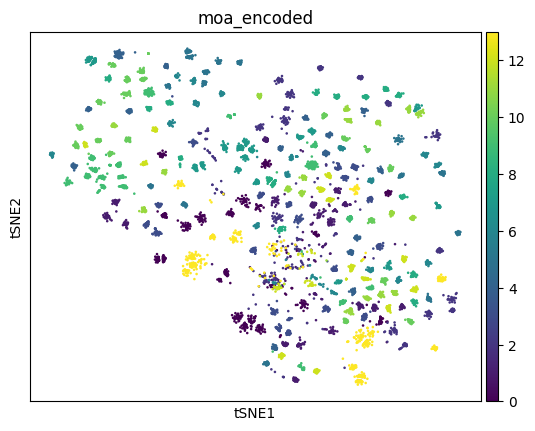

In [205]:
sc.pl.tsne(adata,color='moa_encoded')

In [101]:
feat_df=pd.DataFrame(feat)
feat_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378
0,0.510426,-1.564148,-0.632433,-0.515708,-1.096931,0.389904,0.550402,0.814314,-0.569575,1.734923,...,-0.267058,1.128642,-1.304411,0.149822,0.289577,1.146574,0.241266,0.508362,-0.945244,0.912004
1,0.085033,-0.276252,-0.875577,-0.458836,-0.650674,0.295642,0.478043,0.963273,0.291958,0.064935,...,-0.617851,1.523466,0.105029,-0.346176,-0.118117,1.888405,-0.472329,0.482829,0.455781,0.852567
2,0.190619,-0.837520,0.879094,-0.312788,-0.443692,0.178921,0.302027,-1.387633,-0.337640,-0.454241,...,-0.752695,0.636621,0.281605,1.099846,-0.243713,1.662008,1.581280,1.881972,-0.879136,0.923511
3,0.070848,-0.254438,-0.357114,-0.175513,0.099076,0.258658,0.140526,0.536948,-1.153189,0.229314,...,-1.445132,0.481474,0.967562,0.106049,-0.446770,-1.230268,0.174060,0.403547,-0.310769,0.934344
4,0.262050,1.291678,0.307589,-0.146156,-0.375027,0.435912,0.106441,1.256138,1.070935,0.150426,...,-1.643801,0.201092,0.405935,-0.423955,0.139583,1.052363,1.625207,-0.177415,-1.170798,1.095826


In [102]:
tsne_df

,t-SNE1,t-SNE2,moa_encoded
0,7.139929,-35.985043,1
1,25.366766,-33.612503,1
2,-11.417012,-3.214118,1
3,-9.943036,-11.848834,1
4,-9.930762,-12.216075,1
...,...,...,...
8774,0.709143,9.067085,12
8775,1.618756,7.997007,12
8776,0.921448,8.610720,12
8777,0.715571,8.626685,12


In [104]:
tsne_df['batch_encoded']= combined_df['batch_encoded'].astype("category")
tsne_df.head()

,t-SNE1,t-SNE2,moa_encoded,batch_encoded
0,7.139929,-35.985043,1,160
1,25.366766,-33.612503,1,151
2,-11.417012,-3.214118,1,247
3,-9.943036,-11.848834,1,268
4,-9.930762,-12.216075,1,207


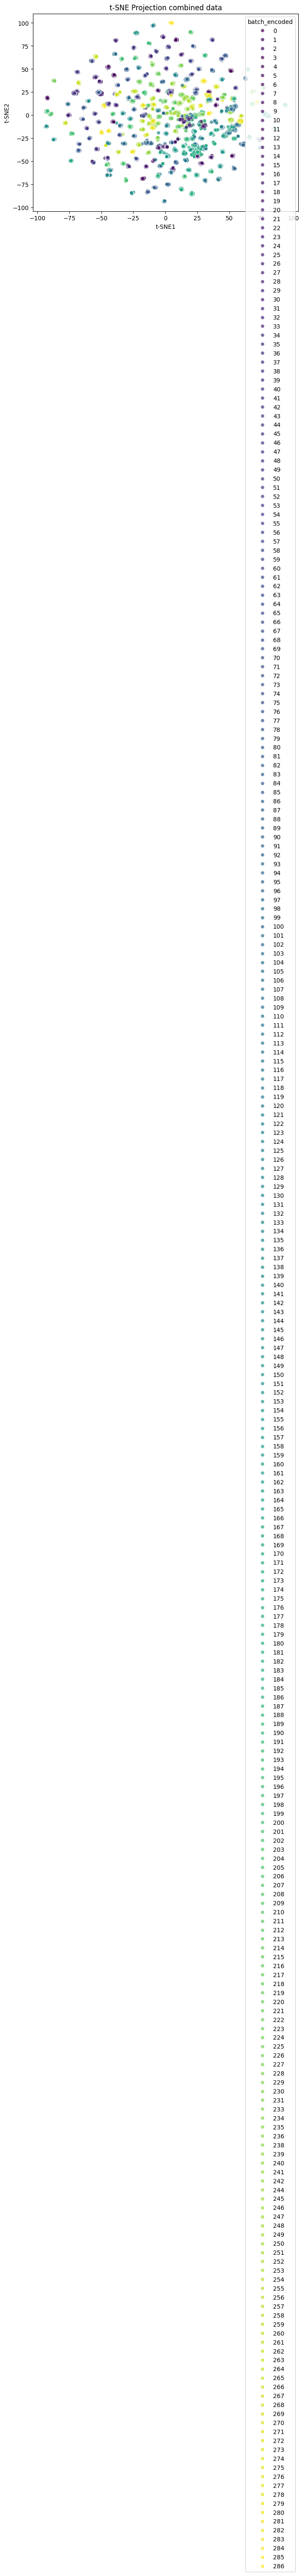

In [105]:
palette = sns.color_palette("viridis", n_colors=len(tsne_df["batch_encoded"].cat.categories))
hue_order = sorted(tsne_df["batch_encoded"].unique())

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="t-SNE1",
    y="t-SNE2",
    hue="batch_encoded",
    palette="viridis",  # Change palette as needed
    data=tsne_df,
    alpha=0.7
)

plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE Projection combined data")
plt.legend(title="batch_encoded")
plt.show()

In [231]:


# Convert PyTorch tensors to NumPy arrays
y_train = y_train.numpy() if hasattr(y_train, 'numpy') else np.array(y_train)
y_val = y_val.detach().cpu().numpy()
y_val = y_val.numpy() if hasattr(y_val, 'numpy') else np.array(y_val)
